In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import re
import xml.etree.ElementTree as ET
from time import sleep
import os
from glob import glob

In [2]:
def w(high, num=1):
    result = np.random.randint(1, high+1, size=num)
    if num==1:
        result = result[0]
    return result
    
w20 = partial(w, 20)
w6 = partial(w, 6)

In [3]:
def talentprobe(
    talentwert,
    eigenschaften,
    modifikator=0,
):
    eigenschaften = np.array(eigenschaften)
    assert len(eigenschaften) == 3, \
        f'Eigenschaften müssen Länge 3 haben.'
    # 3 W20 würfeln
    gewürfelt = w20(3)
    
    # übrige punkte (Tpk*) berechnen
    übrig = eigenschaften - gewürfelt
    if modifikator > talentwert:
        übrig -= (modifikator - talentwert)
        talentwert = 0
    else:
        talentwert -= modifikator
    übrig = np.clip(übrig, a_max=0, a_min=None).sum() + talentwert
    
    # patzer bei mindestens zwei gewürfelten zwanzigen
    patzer = (gewürfelt==20).sum() >= 2
    
    # gücklich bei mindestens zwei einsen
    glücklich = (gewürfelt==1).sum() >= 2
    
    # geschafft wenn punkte übrig und kein patzer
    geschafft = (übrig >= 0) and not patzer
    
    if patzer:
        result_code = -1
    elif glücklich:
        result_code = 2
    elif geschafft:
        result_code = 1
    else:
        result_code = 0
    
    return result_code, dict(
        geschafft = geschafft,
        übrig = übrig,
        patzer = patzer,
        glücklich = glücklich,
        gewürfelt = gewürfelt,
    )


eigenschaften_mapping = dict(
    Mut='MU',
    Klugheit='KL',
    Intuition='IN',
    Charisma='CH',
    Fingerfertigkeit='FF',
    Gewandtheit='GE',
    Konstitution='KO',
    Körperkraft='KK', 
    Sozialstatus='SO',
    Magieresistenz='MR',
    Lebensenergie='LeP',
    Ausdauer='AuP',
)

def parse_eigenschaften(root):
    eigenschaften = root.findall('held/eigenschaften')[0]
    eigenschaften = {eigenschaften_mapping[e.attrib['name']]: int(e.attrib['value'])
                     for e in eigenschaften 
                     if e.attrib['name'] in eigenschaften_mapping}
    assert len(eigenschaften) == len(eigenschaften_mapping), \
        f'Nicht alle eigenschaften gefunden'
    return eigenschaften


def parse_talente(root):
    talentliste = root.findall('held/talentliste')[0]
    result = dict()
    for talent_info in talentliste:
        talent_info = parse_talent(talent_info)
        talentname = talent_info.pop('name')
        result[talentname] = talent_info
    return result

    
def parse_talent(talent_info):
    talent_info = talent_info.attrib.copy()
    talent_info['probe'] = re.match(' \((..)/(..)/(..)\)', talent_info['probe']).groups()
    talent_info['talentwert'] = int(talent_info.pop('value'))
    del talent_info['lernmethode']
    return talent_info


def print_recursive(root, depth=0, hist=()):
    hist = hist + (root.tag,)
    print(hist)
    print(root.attrib)
    for child in root:
        print_recursive(child, depth+1, hist)
        
    
class Held():
    @staticmethod
    def from_xml(path):
        tree = ET.parse(path)
        root = tree.getroot()
        eigenschaften = parse_eigenschaften(root)
        talente = parse_talente(root)
        return Held(root.findall('held')[0].attrib['name'], eigenschaften, talente)
        
    def __init__(self,
        name,
        eigenschaften,
        talente
    ):
        self.name = name
        self.eigenschaften = eigenschaften       
        self.talente = talente
        self.probe = ProbenHelfer(self)
        
    def __repr__(self):
        return self.name
    
    def talentprobe(self, talent, mod=0):
        assert talent in self.talente, \
            f'Held {self.name} kann nicht {talent}'
        eigenschaften = [self.eigenschaften[eigenschaft] for
                        eigenschaft in self.talente[talent]['probe']]
        talentwert = self.talente[talent]['talentwert']
        result = talentprobe(talentwert, eigenschaften, mod)
        result[1]['eigenschaften'] = eigenschaften
        result[1]['talentwert'] = talentwert
        return result
    
    
class ProbenHelfer():
    def __init__(self, held):
        for talent in held.talente:
            attr_name = talent.replace('  ', ' ').replace(' ', '_').replace(':', '').replace('/','')
            setattr(self, attr_name, self._Probe(held, talent))
            
    class _Probe:
        def __init__(self, held, talent):
            self.held = held
            self.talent = talent
            self.talent_info = self.held.talente[self.talent]
            
        def __call__(self, mod=0, in_game=True, delay=1):
            result = self.held.talentprobe(self.talent, mod)
            if in_game:
                for i, augen in enumerate(result[1]['gewürfelt']):
                    print(f'Wurf {i+1}: {augen}')
                    sleep(delay)
                if result[1]['patzer']:
                    print("Patzer! ", w6() + w6())
                elif result[1]['glücklich']:
                    print("Glücklich!")
                elif result[1]['geschafft']:
                    print(f"Geschafft.")
                else:
                    print("Fehlschlag.")
                print(f"Punkte übrig: {result[1]['übrig']}")
            return result
            
        def __repr__(self):
            return str(self.talent_info)
                      
        def prob(self, mod=0, n=10000):
            return monte_carlo_estimate(lambda: self(mod=mod, in_game=False)[0] > 0, n)
        
        def prob_plot(self, mods=None, n=1000):
            mods = np.arange(-7, 8) if mods is None else mods
            probs = [monte_carlo_estimate(lambda: self(mod, in_game=False)[0] > 0, n) 
                     for mod in mods]
            plt.plot(mods, probs)
                      
        def übrig_hist(self, mod=0, n=10000):
            data = [self(mod, in_game=False)[1]['übrig'] for _ in range(n)]
            plt.hist(data, density=True)
            
    
def monte_carlo_estimate(func, n=1000):
    return np.mean([func() for _ in range(n)])

    
# results = [talentprobe(5, (10, 15, 13))[0]
#            for _ in range(1000)]
# np.unique(results, return_counts=True)

# monte_carlo_estimate(lambda: talentprobe(8, (10, 8, 13))[0], 10000)

boromeo = Held.from_xml('/home/roman/Documents/helden-software/exported/3 Boromeo Delazar1.xml')
print(boromeo.name)

Boromeo Delazar1


In [4]:
def pythonize_string(s):
    return s.replace('  ', ' ').replace(' ', '_').replace(':', '').replace('/','')

outcome_to_string = {
    -1: 'Patzer!',
    0: 'Fehlschlag.',
    1: 'Geschafft.',
    2: 'Glücklich!',
}

class Heldengruppe:
    @classmethod
    def from_folder(cls, path):
        return cls(*(Held.from_xml(file) for file in glob(os.path.join(path, '*.xml'))))
                  
    def __init__(self, *helden):
        self.helden = helden
        for talent in set.union(*[set(held.talente.keys()) for held in helden]):
            #print(talent)
            attr_name = pythonize_string(talent)
            setattr(self, attr_name, partial(self.talentprobe, talent))
            
    def talentprobe(self, talent, *args, verbose=True, **kwargs):
        results = {}
        for held in self.helden:
            if talent not in held.talente:
                results[held]=None
                continue
            results[held] = held.talentprobe(talent, *args, **kwargs)
        if verbose:
            for held, result in results.items():
                if result is None:
                    print(f'{held.name:25s}')
                else:
                    print(f'{held.name:25s} {outcome_to_string[result[0]]:12s} {result[1]["übrig"]:3d} übrig.')
        else:
            return results
            
    def __len__(self):
        return self.helden
    
    def __iter__(self):
        return iter(self.helden)
    

#boromeo.probe.Schätzen(delay=2);

In [5]:
# Einen Helden laden
boromeo = Held.from_xml('/home/roman/Documents/helden-software/exported/3 Boromeo Delazar1.xml')

In [6]:
# Probe mit Verzögerung für Spannung :D
# (Das würde ich vielleicht benutzen, 
# wenn Julia unseren einen Würfel gerade hat)
boromeo.probe.Tierkunde(); 

Wurf 1: 12
Wurf 2: 2
Wurf 3: 14
Geschafft.
Punkte übrig: 9


In [7]:
# Für info zu einer Probe: Klammern weglassen
boromeo.probe.Boote_fahren

{'probe': ('GE', 'KO', 'KK'), 'talentwert': 1}

In [9]:
# Eine Gruppe laden
gruppe = Heldengruppe.from_folder('/home/roman/mnt/DSA/Helden/')

In [10]:
# Die ganze Gruppe eine Probe machen lassen
gruppe.Sinnenschärfe(3) # Sinnesschärfe erschwert um 3

Boromeo Delazar1          Geschafft.     1 übrig.
Kiaras Geron ya Caranda   Fehlschlag.   -4 übrig.
Pashkir Alfahan           Geschafft.     5 übrig.


In [68]:
gruppe.Sprachen_kennen_Rssahh()

Boromeo Delazar1          Patzer!       -7 übrig.
Kiaras Geron ya Caranda   Fehlschlag.   -2 übrig.
Pashkir Alfahan          


In [78]:
boromeo.probe.Tierkunde();

Wurf 1: 14
Wurf 2: 3
Wurf 3: 1
Geschafft.
Punkte übrig: 8


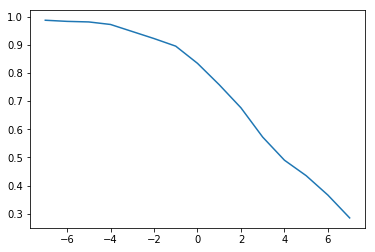

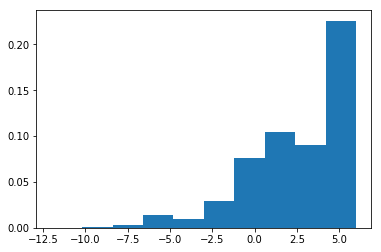

In [85]:
boromeo.probe.Reiten.prob_plot()
plt.show()
boromeo.probe.Reiten.übrig_hist()
plt.show();